# Generating the Dataset

### This set of code initiatives necessary libraries and reads in the simulated list of Naval Bases and billets. This will serve as an example of the Job owners information of potential opportunities for sailors. 

In [1]:
import pandas as pd
import random
import copy
from sklearn import preprocessing
import plotly.plotly as py
import plotly.graph_objs as go
import numpy as np


#Read in the csv of Naval Base information: Name, Lat, Lon, Number of Billets
naval_bases = pd.read_csv("Data/naval_bases.csv")

# Run the normalize the number of billets for the desired number of simulated sailors
naval_bases["Normalized"] = naval_bases["Billets"] / naval_bases["Billets"].sum()
naval_bases.head()

,Name,Billets,Lat,Lon,Normalized
0,CHINA LAKE NAVAL AIR WEAPONS STATION,5,35.66,-117.66,0.007082
1,CORONADO NAVAL AMPHIBIOUS BASE,10,32.68,-117.16,0.014164
2,EL CENTRO NAVAL AIR FACILITY,1,32.81,-115.67,0.001416
3,LEMOORE NAS,2,36.26,-119.91,0.002833
4,MONTEREY NAVAL POSTGRADUATE SCHOOL,2,36.60,-121.87,0.002833


### This section takes the desired number of billets to simulate and disperses them across a normalized range from the Naval Bases input csv.

In [2]:
#Total billets to simulate
total_billets = 1000

#Generate billets based on noramlized values
naval_bases["Billets"] = naval_bases["Normalized"] * total_billets
naval_bases["Billets"] = naval_bases["Billets"].astype("int")

#Get total billets simulated
assigned_billets = naval_bases["Billets"].sum()
print(assigned_billets)

976


### This section takes the desired number of sailors to simulate and randomly generates their top three preferences with a wighting based off of the number of available billets. This is to say that sailors prefer the locations with more available billets.

In [3]:
#Total sailors to simulate
total_sailors = 1000

#Randomly assign each sailor 3 preferences wieghted by the number of billets at each locaiton
sailor_prefernces = []
for i in range(total_sailors):
    sailor_prefernces.append(list(naval_bases.Name.sample(3, replace=False, weights=naval_bases.Billets)))
    sailor_prefernces[i].insert(0,i)
sailor_prefernces = pd.DataFrame(sailor_prefernces, columns=["sailor_ID", "pref_1","pref_2", "pref_3"])
print (len(sailor_prefernces))
sailor_prefernces.head()

1000


,sailor_ID,pref_1,pref_2,pref_3
0,0,"DAM NECK FLEET COMBAT TRAINING CENTER, ATLANTIC",NORFOLK NAVAL SHIPYARD,NORFOLK NB
1,1,U.S. NAVAL ACADEMY,PENSACOLA NAS,NORFOLK NB
2,2,NORFOLK NB,SAN DIEGO NS,NORFOLK NAVAL SHIPYARD
3,3,NORFOLK NB,BEAUFORT NAVAL HOSPITAL,SAN DIEGO NS
4,4,NORTH ISLAND NAS,BANGOR NAVAL SUBMARINE BASE,Naval Support Activity Mid-South


### This section takes all of the sailors interested in a given billet and then randomizes the job owners preferences for those sailors.

In [4]:
#Set up the job owner prefences, these are a randomized ordering of all sailors wanting to go to that billet
job_owner_prefernces = []
for base in list(naval_bases.Name):
    first = sailor_prefernces.loc[sailor_prefernces['pref_1'] == base]
    second = sailor_prefernces.loc[sailor_prefernces['pref_2'] == base]
    third = sailor_prefernces.loc[sailor_prefernces['pref_3'] == base]
    sailors = pd.concat([first,second,third]).drop_duplicates("sailor_ID", keep="first")
    job_owner_prefernces.append([base,list(sailors.sailor_ID)])
job_owner_prefernces = pd.DataFrame(job_owner_prefernces,columns=["job_owner", "sailors"])
job_owner_prefernces.head()

,job_owner,sailors
0,CHINA LAKE NAVAL AIR WEAPONS STATION,"[20, 58, 158, 169, 204, 206, 506, 526, 597, 80..."
1,CORONADO NAVAL AMPHIBIOUS BASE,"[67, 72, 120, 135, 188, 211, 249, 288, 423, 63..."
2,EL CENTRO NAVAL AIR FACILITY,"[308, 667, 81, 229]"
3,LEMOORE NAS,"[375, 438, 474, 472, 436, 437, 708, 742, 962]"
4,MONTEREY NAVAL POSTGRADUATE SCHOOL,"[112, 184, 803, 377, 498, 583, 598, 658, 937, ..."


### This section sums up the given sailors preferences for each of the potential commands

In [5]:
pref_1 = sailor_prefernces.groupby('pref_1').count()
pref_2 = sailor_prefernces.groupby('pref_2').count()
pref_3 = sailor_prefernces.groupby('pref_3').count()
naval_bases_hold = naval_bases.set_index("Name")
prefs = pd.concat([pref_1.sailor_ID, pref_2.sailor_ID,pref_3.sailor_ID,naval_bases_hold.Billets], axis=1)
prefs.columns = ["pref_1","pref_2","pref_3", "Billets"]
prefs.head()

,pref_1,pref_2,pref_3,Billets
ANNAPOLIS NS,9.0,10.0,16.0,14
BANGOR NAVAL SUBMARINE BASE,44.0,46.0,61.0,42
BEAUFORT NAVAL HOSPITAL,8.0,6.0,3.0,5
BETHESDA NATIONAL NAVAL MEDICAL CENTER,12.0,10.0,12.0,11
BREMERTON NAVAL STATION,19.0,14.0,15.0,14


### This section of code reshapes the various dataframes for running within the algorithm as well as for mapping.

In [6]:
#Shape dataframes into dictionaries for mathcing

#Sailors
sailor_prefernces_dict = sailor_prefernces.set_index('sailor_ID').T.to_dict('list')
sailor_prefernces_store = sailor_prefernces.set_index('sailor_ID').T.to_dict('list')

#Job Owners
job_owner_prefernces_dict = job_owner_prefernces.set_index('job_owner').T.to_dict('records')[0]

#Capacities
billets = pd.Series(naval_bases.Billets.values,index=naval_bases.Name).to_dict()

#Shape dataframes for graphing
#Billets
graph_bases = naval_bases.loc[naval_bases.index.repeat(naval_bases.Billets)]

### This section of code visualizes the available billets in a heatmap

In [7]:
import folium
from folium import plugins

m = folium.Map([41.8781, -87.6298], zoom_start=4)

# convert to (n, 2) nd-array format for heatmap
billet_loc = graph_bases[['Lat', 'Lon']].as_matrix()
# Add AOI to the markers***
billet_info = graph_bases["Name"].as_matrix()

# plot heatmap
hm = plugins.HeatMap(billet_loc.tolist(), name="Billet HeatMap")
m.add_child(hm)

# plot markers
hm = plugins.MarkerCluster(locations = billet_loc.tolist(), popups = billet_info.tolist(), name="Billets")
m.add_child(hm)

#Add Layer Control
# add the layer control
folium.LayerControl().add_to(m)


m

### This section of code runs through the algorithm to solve a stable marriage problem with given capacities for each of the suitors. 

The algorithm which solves this problem is famously utilised in the USA by the National Resident Matching Program, hence the nickname. In fact, research surrounding this algorithm won Shapley, along with Alvin Roth, the Nobel Prize for Economics in 2012. 

For our simulation, the hospitals will represent the represented job owners at each of the available commands. The residents will represent the sailors, and the capacities will be the number of billets available at each location. 



In [8]:
def check_inputs(owner_prefs, sailor_prefs):
    """ Reduce as necessary the preference list of all residents and hospitals
    so that no player ranks another player that they are not also ranked by. """
    for sailor in sailor_prefs.keys():
        for billet in sailor_prefs[sailor]:
            if sailor not in owner_prefs[billet]:
                print (sailor)
                print (owner_prefs[billet])
                raise ValueError(
                    'Hospitals must rank all residents who rank them.'
                )


def get_free_sailors(sailor_prefs, matching, matched_sailors):
    """ Return a list of all residents who are currently unmatched but have a
    non-empty preference list. """
    free_list = []

    for sailor in sailor_prefs:
        if sailor_prefs[sailor] and sailor not in matched_sailors:#any([resident in match for match in matching.values()]):
            free_list.append(sailor)

    return free_list


def get_worst_idx(billet, owner_prefs, matching):
    """ Find the index of the worst sailor currently assigned to `billet`
    according to their preferences. """

    return max(
        [
            owner_prefs[billet].index(sailor)
            for sailor in owner_prefs[billet]
            if sailor in matching[billet]
        ]
    )


def dynamic_manning(owner_prefs, sailor_prefs, capacities):
    """ Provide a stable, sailor-optimal matching for the given instance of
    billet capacities using the algorithm set out in [Dubins, Freeman 1981]. """

    #Verify that all job owners and sailors have ranked each other
    check_inputs(owner_prefs, sailor_prefs)

    #Create an empty dictionary that contains all of the available billet options.
    # This will be what the algorithm returns
    matching = {billet: [] for billet in owner_prefs}
    
    #Keep a running list of matched sailors for speed improvement on look-up
    matched_sailors = {}
    
    #Get all of the available sailors left to be assigned
    free_sailors = get_free_sailors(sailor_prefs, matching, matched_sailors)
    
    #This counter shows the number of interacitons that must be done in order to complete the algorithm
    count = 0
    
    #This loop continues as long as there are sailors left to be assigned
    while free_sailors:
        
        #Increase the counter for each time a new sailor needs to be assigned
        count += 1
        
        #Consider the sailor at the top, index 0, of the available sailors
        sailor = free_sailors[0]
        
        #Consider the top billet preference of the given sailor
        billet = sailor_prefs[sailor][0]
        
        #Add the sailor to their top billet in the output array
        matching[billet].append(sailor)
        
        #Add sailor to the matched sailor dictionary
        matched_sailors[sailor] = "" 
        
        #If there are more sailors assigned to this billet that positons available...
        if len(matching[billet]) > capacities[billet]:
            #Find the sailor who the job owner prefers the least currently in the job
            worst = get_worst_idx(billet, owner_prefs, matching)
            sailor = owner_prefs[billet][worst]
            
            #Remove them from this position
            matching[billet].remove(sailor)
            
            #Remove sailor from matched
            del matched_sailors[sailor]

        # If the billet is at capacity, and at this point the owner has filled all of their jobs
        if len(matching[billet]) == capacities[billet]:
            
            #Find the sailor who the job owner prefers the least currently in the job
            worst = get_worst_idx(billet, owner_prefs, matching)
            
            #Find all sailors who listed the billet in their preferences, 
            #but are less desired than those currently slated the job.
            successors = owner_prefs[billet][worst + 1:]

            #If there are any of these such sailors,
            if successors:
                
                #Iterate through them
                for sailor in successors:
                    
                    #Increase the count for number of interations
                    count += 1

                    #Remove each of the less desred sailors from the owners preferences
                    owner_prefs[billet].remove(sailor)
                    
                    #If the billet is in the sailors preferences,
                    if billet in sailor_prefs[sailor]:
                        
                        #Remove the billet from the sailors preferences to manage memory later on
                        sailor_prefs[sailor].remove(billet)
                        
        #Get the remaining free residents and restart the while loop
        free_sailors = get_free_sailors(sailor_prefs, matching, matched_sailors)

    #Organize all sailors by in their billets by owners preference for clarity
    for billet, matches in matching.items():
        sorted_matches = sorted(matches, key=owner_prefs[billet].index)
        matching[billet] = sorted_matches
    
    #Return matching data as well as interaction count
    return matching, count

#Run algorithm
match, count = dynamic_manning(job_owner_prefernces_dict, sailor_prefernces_dict, billets)


### This section of code shows the breakdown of sailors and which preference they were allocated.

[921, 21, 10, 24]


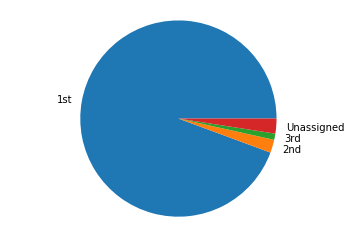

In [24]:
import matplotlib.pyplot as plt
#verify Results and Show Preferences
sailor_results = []
for base, sailors in match.items():
    for member in sailors:
        prefernce = sailor_prefernces_store[member].index(base)
        sailor_results.append([member, prefernce + 1])
results = pd.DataFrame(sailor_results, columns=["Sailors", "preference_received"])
hold = results.groupby('preference_received').count()
preferences = hold['Sailors'].values.tolist()

#Data Verification
flat_list = pd.Series([item for sublist in list(match.values()) for item in sublist])
duplicates = (flat_list.value_counts().max()) - 1
unassigned = -1* (len(flat_list.values) - assigned_billets)

labels = ['1st','2nd','3rd','Unassigned']
preferences.append(unassigned)

fig1, ax1 = plt.subplots()
ax1.pie(preferences, labels=labels)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()